# Chapter 14: Recurrent Neural Networks

#### Introduction

* RNNs can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have seen so far.

* A limitation of Vanilla Neural Networks (and also Convolutional Networks) is that they accept a fixed-sized vector as input (e.g. an image) and produce a fixed-sized vector as output (e.g. probabilities of different classes). Recurrent nets are more exciting as they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both.

* They work specially well for NLP (translation, sentiment analysis, speech-to-text) and audio processing.

* Possible problems are vanishing/exploding gradients. Some ways to deal with them are LSTM and GRU cells.

* The main difference to what was seen so far (ANN, DNN, CNN) is that these NNs are not just feed-forward, but there are edges pointing backwards as well. Meaning, neurons at step $i-1$ and layer $l+a$ can connect to neurons at step $i$ and layer $l$.

<img src="files/rnn_vis_rep.png">

#### Notes

* A neurons' output at step $t$ with activation function $\phi$ is computed as: 

    $y_{(t)} = \phi([X_{(t)} \ Y_{(t-1)}] \ [W_X^T \ W_Y^T]^T + b)$

* Many researchers prefer to use the hyperbolic tangent (tanh) activation function in RNNs rather than the ReLU activation function.

## Static RNN mostly by-hand

In [6]:
import numpy as np
import tensorflow as tf

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))

b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

# Mini-batch: instance 0,instance 1,instance 2,instance 3 
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0 
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess: 
    tf.global_variables_initializer().run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

print(Y0_val)
print(Y1_val)

[[ 0.58439076 -0.38200927  0.99478775  0.8522754  -0.8493073 ]
 [ 0.9806192  -0.99999845  1.         -0.97370476 -0.9430899 ]
 [ 0.9992702  -1.          1.         -0.9999717  -0.9791651 ]
 [ 0.9804596  -1.         -0.00249966 -1.          0.94248176]]
[[ 0.99747205 -1.          1.         -1.         -0.58356255]
 [-0.28376576  0.9767532   0.97486055 -0.9937281  -0.0887477 ]
 [ 0.9819391  -1.          1.         -1.          0.16745734]
 [ 0.7856287  -0.99998313  0.9999999  -0.99994963  0.25155604]]


## Static RNN using TF

In [7]:
tf.reset_default_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

(Y0, Y1), states = tf.contrib.rnn.static_rnn(
    basic_cell, 
    [X0, X1], 
    dtype=tf.float32)

with tf.Session() as sess: 
    tf.global_variables_initializer().run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

print(Y0_val)
print(Y1_val)

[[-0.06642583  0.46275124  0.4414053   0.8132189  -0.01677922]
 [ 0.91791415  0.97197455  0.96184903  0.9910163  -0.5952722 ]
 [ 0.996798    0.99890083  0.9980502   0.99960476 -0.87518233]
 [ 0.9738824   0.99407154  0.9951182  -0.59644467 -0.8149797 ]]
[[ 0.9999394   0.9989903   0.9995799   0.9974815  -0.9773649 ]
 [ 0.85723865 -0.94109917 -0.2162181  -0.47883582 -0.14565074]
 [ 0.99988145  0.67858386  0.97892106  0.8785653  -0.91591734]
 [ 0.9941524  -0.04822242  0.00221991 -0.44518748 -0.6348825 ]]


## Static RNN using TF for variable time steps

In [13]:
n_steps = 2

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # [Batch, Step, Feature]
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2])) # Step x [Batch, Feature]

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2]) # [Batch, Step, Feature]

X_batch = np.array([
        #t = 0 t = 1
        [[0, 1, 2], [9, 8, 7]], # instance 0 
        [[3, 4, 5], [0, 0, 0]], # instance 1 
        [[6, 7, 8], [6, 5, 4]], # instance 2 
        [[9, 0, 1], [3, 2, 1]], # instance 3
    ])

with tf.Session() as sess: 
    tf.global_variables_initializer().run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[-0.8840808  -0.91466177  0.96305513  0.51237    -0.52004665]
  [-0.9998389  -0.99860585  0.9999214  -0.9733922  -1.        ]]

 [[-0.9978306  -0.9973324   0.9994389  -0.1154042  -0.99889827]
  [ 0.02441876  0.53090584  0.7332013   0.29456207 -0.16947564]]

 [[-0.9999616  -0.9999199   0.99999154 -0.66279364 -0.99999815]
  [-0.98844236 -0.8091579   0.9970866  -0.9458143  -0.99999255]]

 [[ 0.23881228  0.99957734 -0.99989897 -0.9998869  -0.999837  ]
  [-0.5354684   0.46231174 -0.24938744 -0.8994993  -0.9868713 ]]]


## Dynamic RNN using TF with variable time steps per instance

In [21]:
n_steps = 2

tf.reset_default_graph()

seq_length = tf.placeholder(tf.int32, [None])
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # [Batch, Step, Feature]

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

outputs, states = tf.nn.dynamic_rnn(
    basic_cell, 
    X, 
    dtype=tf.float32, 
    sequence_length=seq_length)

X_batch = np.array([
        #t = 0 t = 1
        [[0, 1, 2], [9, 8, 7]], # instance 0 
        [[3, 4, 5], [0, 0, 0]], # instance 1 # only one time step
        [[6, 7, 8], [6, 5, 4]], # instance 2 
        [[9, 0, 1], [3, 2, 1]], # instance 3
    ])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess: 
    tf.global_variables_initializer().run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})
    
print(outputs_val)

[[[ 0.14262824 -0.898237    0.26409262  0.9098908   0.7985182 ]
  [ 0.9475035  -0.99948245 -0.8759814   1.         -0.9803118 ]]

 [[ 0.7974842  -0.9966856  -0.27770266  0.9999973   0.629874  ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9667288  -0.99989736 -0.6862774   1.          0.36955237]
  [ 0.91824174 -0.98103124 -0.25563815  0.99999994 -0.94377196]]

 [[-0.2963333   0.9720922  -0.9998182   0.9999917  -0.9999707 ]
  [ 0.7111934  -0.81178063 -0.83215785  0.9998305  -0.60253763]]]


## MNIST using RNNs

In [23]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, 28, 28))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [24]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Instructions for updating:
Use keras.layers.dense instead.


In [26]:
n_epochs = 10
batch_size = 150

n_batches = (mnist.train.num_examples // batch_size)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.91333336 Test accuracy: 0.928
1 Train accuracy: 0.9266667 Test accuracy: 0.9403
2 Train accuracy: 0.94666666 Test accuracy: 0.9523
3 Train accuracy: 0.96666664 Test accuracy: 0.9632
4 Train accuracy: 0.94 Test accuracy: 0.9621
5 Train accuracy: 0.96 Test accuracy: 0.9638
6 Train accuracy: 0.9866667 Test accuracy: 0.9726
7 Train accuracy: 0.97333336 Test accuracy: 0.9678
8 Train accuracy: 0.97333336 Test accuracy: 0.9684
9 Train accuracy: 0.9866667 Test accuracy: 0.9716


## Stock prices using RNNs

In [60]:
import pandas as pd
stock_dataset_pd = pd.read_csv('AMZN.txt', 
                            delimiter='\t', 
                            names=['date', 'movement_percent', 'open_price', 'high_price', 'low_price', 'close_price', 'volume']
                           )

In [69]:
print(stock_dataset_pd[:1])

def pd_to_tf_dataset(dataset, features, target):
    return tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset[features].values, tf.float32),
            tf.cast(dataset[target].values, tf.int32)
        )
    )

def pd_to_xy_dataset(dataset, features, target):
    return dataset[features].values, dataset[target].values

_, prices = pd_to_xy_dataset(stock_dataset_pd, [], 'high_price')

         date  movement_percent  open_price  high_price  low_price  \
0  2017-09-01         -0.002396    0.003671    0.003977  -0.003794   

   close_price     volume  
0    -2.349976  2532200.0  


In [72]:
print(prices)

[0.003977 0.013859 0.016089 ... 0.031983 0.026318 0.002945]


In [82]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # [batch_size, n_steps, n_inputs]
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs]) # [batch_size, n_steps, n_outputs]

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) # n_inputs -> n_neurons

rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # [batch_size, n_steps, n_neurons]
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) # [batch_size * n_steps, n_neurons]
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # [batch_size * n_steps, n_outputs]
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) # [batch_size, n_steps, n_outputs]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [90]:
save_path_1 = "./c14_1.ckpt"

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        i_s = np.random.randint(
            low=0, 
            high=len(prices)-n_steps*max(n_inputs,n_outputs)-2,
            size=batch_size)
        X_batch = np.reshape([prices[i:i+n_steps*n_inputs] for i in i_s], (batch_size, n_steps, n_inputs))
        y_batch = np.reshape([prices[i+1:i+1+n_steps*n_outputs] for i in i_s], (batch_size, n_steps, n_outputs))
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    tf.train.Saver().save(sess, save_path_1)

0 	MSE: 0.00026767355
100 	MSE: 0.00028233463
200 	MSE: 0.00021487677
300 	MSE: 0.00022764345
400 	MSE: 0.00022538588
500 	MSE: 0.0001132063
600 	MSE: 0.00013923978
700 	MSE: 0.0001441279
800 	MSE: 0.00013097611
900 	MSE: 0.00015173419
1000 	MSE: 0.00011534667
1100 	MSE: 0.0001385231
1200 	MSE: 9.836824e-05
1300 	MSE: 0.00010289323
1400 	MSE: 7.437316e-05


In [85]:
import matplotlib
import matplotlib.pyplot as plt

def simple_plot(f, title=''):
    x = np.arange(0, len(f), 1)
    fig, ax = plt.subplots()
    ax.plot(x, f)
    ax.set(xlabel='x', ylabel='f(x)', title=title)
    ax.grid()
    plt.show()

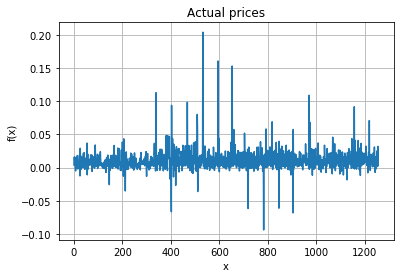

In [86]:
simple_plot(prices, "Actual prices")

In [128]:
past_prices = 20

with tf.Session() as sess:
    tf.train.Saver().restore(sess, save_path_1)
    sequence = prices[:past_prices]
    for iteration in range(len(prices)-past_prices):
        X_batch = np.array(sequence[iteration:iteration+n_steps]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence = np.append(sequence, y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./c14_1.ckpt


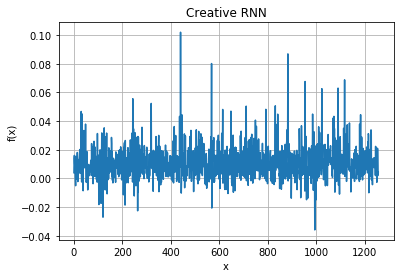

In [129]:
simple_plot(sequence, "Creative RNN")

## Deep RNNs

In [133]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_layers = 3
n_outputs = 1

learning_rate = 0.001

tf.reset_default_graph()

keep_prob = tf.placeholder_with_default(1.0, shape=())
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # [batch_size, n_steps, n_inputs]
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs]) # [batch_size, n_steps, n_outputs]

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]

cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)

rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) # [batch_size * n_steps, n_neurons]
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # [batch_size * n_steps, n_outputs]
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) # [batch_size, n_steps, n_outputs]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [141]:
save_path_2 = "./c14_2.ckpt"

n_iterations = 500
batch_size = 50

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        i_s = np.random.randint(
            low=0, 
            high=len(prices)-n_steps*max(n_inputs,n_outputs)-2,
            size=batch_size)
        X_batch = np.reshape([prices[i:i+n_steps*n_inputs] for i in i_s], (batch_size, n_steps, n_inputs))
        y_batch = np.reshape([prices[i+1:i+1+n_steps*n_outputs] for i in i_s], (batch_size, n_steps, n_outputs))
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            X_batch = np.reshape([prices[i:i+n_steps*n_inputs] for i in range(1200)], (-1, n_steps, n_inputs))
            y_batch = np.reshape([prices[i+1:i+1+n_steps*n_outputs] for i in range(1200)], (-1, n_steps, n_outputs))
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    tf.train.Saver().save(sess, save_path_2)

0 	MSE: 0.005340926
100 	MSE: 0.00025477633
200 	MSE: 0.00025399379
300 	MSE: 0.00025459938
400 	MSE: 0.00025375193


## LSTM Cells

* The Long Short-Term Memory (LSTM) cell was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber.
* The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it.

<img src="files/lstm_diagram.png">

* The main layer is the one that outputs g(t).
* The forget gate (controlled by f(t)) controls which parts of the long-term state should be erased.
* The input gate (controlled by i(t)) controls which parts of g(t) should be added to the long-term state.
* The output gate (controlled by o(t)) controls which parts of the long-term state should be read and output at this time step (both to h(t)) and y(t).

<img src="files/lstm_equations.png">

* There is an LSTM variant with extra connections called peephole connections: the previous long-term state c(t–1) is added as an input to the controllers of the forget gate and the input gate, and the current long-term state c(t) is added as input to the controller of the output gate.


* In TF:


    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)


## GRU Cell

* The Gated Recurrent Unit (GRU) cell is a simplified version of the LSTM cell, and it seems to perform just as well.

* In TF:


    gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

<img src="files/gru_diagram.png">

## NLP using RNNs

In [ ]:
vocabulary_size = 50000
embedding_size = 150

init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])  # from ids...
embed = tf.nn.embedding_lookup(embeddings, train_inputs)  # ...to embeddings